# Phase Imaging from Defocus
Written by Kristina Monakhova based on: [G. Gunjala, L. Waller, Open Source PhaseGUI, UC Berkeley (2014)](http://www.laurawaller.com/opensource/)

Simple demo showing how to get back the phase of an image using an in-focus image and two out of focus images.  Uses Gerchberg-Saxton.

### Initializations

In [1]:
%matplotlib inline

import numpy as np   
import matplotlib.pyplot as plt            # For making figures
import numpy.fft as fft                    # FFTs
from scipy import misc
from scipy import ndimage
import myfunctions as mf

### Options

In [5]:
# Define Image paths: 
amplitude_path = 'images/testdog.png'
phase_path = 'images/cameraman.tif'

# Options
numIterations = 15      # number of iterations to use

# System parameters 
d_pix = 5.4             # um/pixel (on camera sensor)
M = 8.0                 # System magnification 
dx = d_pix/M            # um/pixel with magnification 
lmda = 0.530            # wavelength of light (um) 
k = 2.0*np.pi/lmda      # wave number 

z_defocus_guess = 495.5 # defocus (um)
zs = np.zeros(1); zs[0] = z_defocus_guess

### Read in Files, Define Complex Field

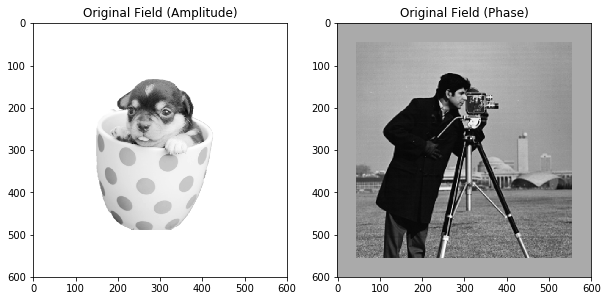

In [6]:
# Read in Images   
im1 = mf.rgb2gray(np.double(misc.imread(amplitude_path)))
im2 = np.double(misc.imread(phase_path))
im2_resized = np.ones(im1.shape)*170
im2_resized[44:556, 44:556] = im2

# Complex field   
g_in = np.sqrt(im1)*np.exp(1j*np.pi*im2_resized/np.max(im2_resized))
    
f, axs = plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(np.abs(g_in), cmap='gray'); 
plt.title('Original Field (Amplitude)');
plt.subplot(1,2,2); plt.imshow(np.angle(g_in), cmap='gray'); 
plt.title('Original Field (Phase)');

### Generate Simualted Defocused Images 

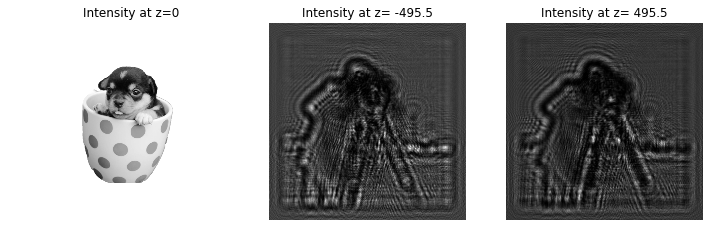

In [11]:
# Intensity at z=0  
I0 = np.abs(g_in)**2    
# Intensity at z = -zs
Im = np.abs(np.squeeze(mf.propagate(g_in, lmda, -zs, dx)[0]))**2
# Intensity at z = +zs
Ip = np.abs(np.squeeze(mf.propagate(g_in, lmda, zs, dx)[0]))**2

f, axs = plt.subplots(1,3,figsize=(12,10));
plt.subplot(1,3,1); plt.imshow(I0, cmap='gray'); 
plt.title('Intensity at z=0'); plt.axis('off');
plt.subplot(1,3,2); plt.imshow(Im, cmap='gray'); 
plt.title("Intensity at z= %1.1f" %-zs[0]); plt.axis('off');
plt.subplot(1,3,3); plt.imshow(Ip, cmap='gray'); 
plt.title("Intensity at z= %1.1f" %zs[0]); plt.axis('off');

### Use Gerchberg-Saxton to Solve for Phase

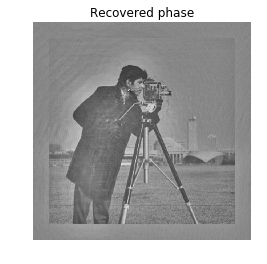

In [21]:
[n,m] = I0.shape;
aest0 = np.sqrt(I0)*np.exp(1j*np.zeros([n,m]));
recovery_animation = np.zeros((n,m,numIterations))
    
for iternum in range(0,numIterations):
    #Propagate from I0 to Ip and replace intensity with measurement
    aest1 = np.squeeze(mf.propagate(aest0, lmda, zs, dx)[0]);
    aest1 = np.sqrt(Ip)*np.exp(1j*np.angle(aest1));

    #Propagate from Ip to I0 and replace intensity with measurement
    aest0 = np.squeeze(mf.propagate(aest1, lmda, -zs, dx)[0]);
    aest0 = np.sqrt(I0)*np.exp(1j*np.angle(aest0));

    #Propagate from I0 to Im and replace intensity with measurement
    aestm1 = np.squeeze(mf.propagate(aest0, lmda, -zs, dx)[0]);
    aestm1 = np.sqrt(Im)*np.exp(1j*np.angle(aestm1));

    #Propagate from Im to I0 and replace intensity with measurement
    aest0 = np.squeeze(mf.propagate(aestm1, lmda, zs, dx)[0]);
    aest0 = np.sqrt(I0)*np.exp(1j*np.angle(aest0));
    
    print('Iteration Number: ', iternum, end='\r')
    
    recovery_animation[:,:,iternum] = np.angle(aest0)

plt.imshow(np.angle(aest0[:,:]), cmap='gray')
plt.title('Recovered phase'); plt.axis('off');

In [22]:
mf.interactive_slider(recovery_animation, 'Recovered Phase')           # Make interactie slider